In [621]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import randint, bernoulli, binom, nbinom, geom, poisson, chi2, hypergeom, norm
eps = 0.05

Linear Generator

In [622]:
class LCG: 
    def __init__(self, a, c, m, start, n):
        self.a = a
        self.c = c
        self.m = m
        self.start = start
        self.generated = []
        self.count_n_items(n)
        self.U = [i / self.m for i in self.generated]

    
    def __str__(self) -> str:
        return "Linear Congruent Generator:\n x_n+1 = ({} * x_n + {}) mod {};  x0 = {}.".format(self.a, self.c, self.m, self.start)

    def count_next(self):
        if len(self.generated) == 0:
            return (self.a * self.start + self.c) % self.m
        elif len(self.generated) > 0:
            return (self.a * self.generated[len(self.generated) - 1] + self.c) % self.m 

    def count_n_items(self, n):
        for i in range(n+300):
            self.generated.append(self.count_next())
    
    def get_mean(self, n):
        return np.mean(self.U[:n])
    
    def get_var(self, n):
        return np.var(self.U[:n])

Macloren-Marsalgia generator

In [623]:
class MMG:
    def __init__(self, generator1, generator2, k, n):
        self.X = generator1
        self.Y = generator2
        self.k = k
        self.n = n
        self.V = [self.X.generated[i] for i in range(k)]
        self.U = [0 for _ in range(n)]
        self.generate()
    
    def generate(self):
        for i in range(self.n):
            s = math.floor(self.Y.generated[i] * self.k / self.Y.m)
            self.U[i] = self.V[s] / self.X.m 
            self.V[s] = self.X.generated[i+self.k]
    
    def get_mean(self, n):
        return sum(self.U[:n]) / n
    
    def get_var(self, n):
        m = 1 / n * sum(self.U[:n])
        return sum([(self.U[i] - m)**2 for i in range(n)]) / (n - 1)
            

Используемый генератор Маклорена-Марсальи, который прошел все тест в л.р. 1

In [624]:
n1 = 10**4
n2 = 10**6
generator_12 = LCG(75, 74, 2**16+1, 7, n2*10)
generator_13 = LCG(25214903917, 11,2**48, 2**8, n2*10)
# генератор Маклорена-Марсальи
mmg = MMG(generator_12, generator_13, 128, n2*10)

Случайный генератор

In [625]:
generator = [random.random() for _ in range(100000)]

Хи-квадрат

In [626]:
def chisquare(freq_obs, freq_exp):
    chisquare = 0.0
    for i in range(len(freq_obs)):
        chisquare += ((freq_obs[i] - freq_exp[i])**2 / freq_exp[i])
    return chisquare

Распределение Бернулли

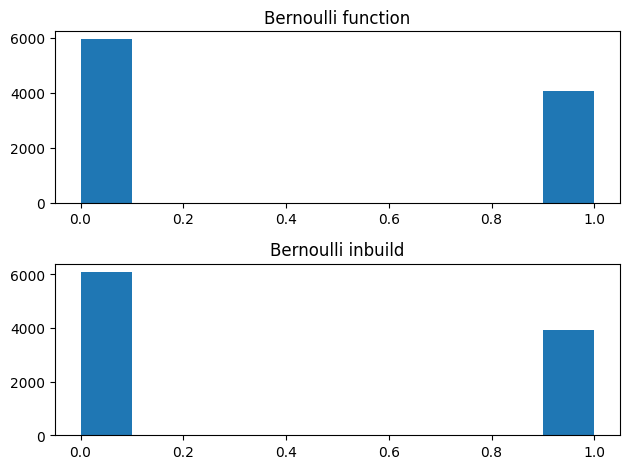

In [627]:
p_bernoulli = 0.4
def bernoullii(p, n):
    return [1 if mmg.U[i] < p else 0 for i in range(n)]

bernoulli_sample = bernoullii(p_bernoulli, n1)
bernoulli_inb = bernoulli.rvs(p_bernoulli, size = n1)


fig, axs = plt.subplots(2,1)
axs[0].hist(bernoulli_sample, histtype = 'bar')
axs[0].set_title("Bernoulli function")
axs[1].hist(bernoulli_inb)
axs[1].set_title("Bernoulli inbuild")
fig.tight_layout()
plt.show()

Хи-квадарт для распределения Бернулли

In [628]:
def observed_bern(bern_sample):
    freq_1 = sum(bern_sample)
    freq_0 = len(bern_sample) - freq_1
    return [freq_0, freq_1]
def expected_bern(bern_sample, p):
    freq_1 = len(bern_sample) * p
    freq_0 = len(bern_sample) * (1-p)
    return [freq_0, freq_1]

freq_exp = expected_bern(bernoulli_inb, p_bernoulli)
freq_obs = observed_bern(bernoulli_inb)
chi_2 = chisquare(freq_obs, freq_exp)
k_my = len(freq_exp)

freq_exp_my = expected_bern(bernoulli_sample, p_bernoulli)
freq_obs_my = observed_bern(bernoulli_sample)
chi_2_my = chisquare(freq_obs_my, freq_exp_my)
k_my = len(freq_exp_my)
delta = chi2(k_my - 1).ppf(1 - eps)
print("Распределение Бернулли:")
print("Хи-квадрат для встроенного генератора: {},\n\
Хи-квадарат для реализованного генератора: {}\n\
Дельта: {}".format(chi_2, chi_2_my, delta))

Распределение Бернулли:
Хи-квадрат для встроенного генератора: 2.8016666666666667,
Хи-квадарат для реализованного генератора: 2.16
Дельта: 3.841458820694124


Дискретное равномерное распределение

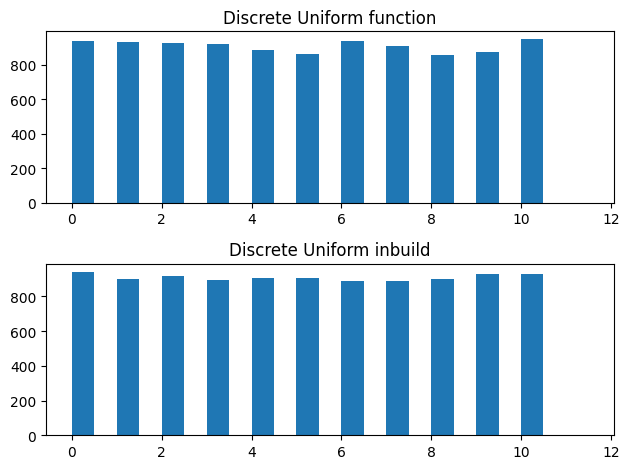

In [629]:
def uniform_pmf(k, a, b):
    n = b - a + 1
    if a <= k <= b:
        return 1/n
    else: 
        return 0 

def discrete_distribution(a, b, n = n1):
    x = [math.floor((b - a + 1) * mmg.U[i]) + a for i in range(n)]
    return x
a, b = 0, 10

# генерация дискретного равномерного распределения
discrete_sample = discrete_distribution(a,b)

# встроенная функция
discrete_sample_inbuild = randint.rvs(low = a, high = b + 1, size=n1)

bin = np.arange(0,12,0.5)
fig, axs = plt.subplots(2,1)
axs[0].hist(discrete_sample, bins = bin)
axs[0].set_title("Discrete Uniform function")
axs[1].hist(discrete_sample_inbuild, bins =bin)
axs[1].set_title("Discrete Uniform inbuild")
fig.tight_layout()
plt.show()

Хи-квадрат равномерного распределения

In [630]:
last = a + b
def expected_uni(a, b):
    freq_exp = []
    sum_prob = 0
    for i in range(last):
        prob = uniform_pmf(i, a, b)
        sum_prob += prob
        freq_exp.append(prob * n1)
    freq_exp.append(n1 * (1 - sum_prob))
    return freq_exp

def observed_uni(sample):
    f_obs = []
    for i in range(last + 1):
        f_obs.append(0)
    sample_sorted = sorted(sample)
    for elem in sample_sorted:
        if elem < last:
            f_obs[elem] += 1
        else:
            f_obs[last] += 1 
    return f_obs

freq_exp = expected_uni(a, b)
freq_obs = observed_uni(discrete_sample_inbuild)
chi_2 = chisquare(freq_obs, freq_exp)

freq_exp_my = expected_uni(a, b)
freq_obs_my = observed_uni(discrete_sample)
chi_2_my = chisquare(freq_obs_my, freq_exp_my)
k = len(freq_exp) - 1
delta = chi2(k - 1).ppf(1 - eps)

print("Дискретное равномерное распределение:")
print("Хи-квадрат для встроенного генератора: {},\n\
Хи-квадарат для реализованного генератора: {}\n\
Дельта: {}".format(chi_2, chi_2_my, delta))

Дискретное равномерное распределение:
Хи-квадрат для встроенного генератора: 3.3516000000000807,
Хи-квадарат для реализованного генератора: 11.711600000000164
Дельта: 16.918977604620448


Биномиальное распределение

In [631]:
       
def factorial(n):
    x = 1
    for i in range(1, n+1):
         x *= i
    return x

def combination(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

def binompmf(k,n,p):
    return combination(n,k)*(p**k)*((1-p)**(n-k))

def binomial(n, p):
    bern = bernoullii(p, n*n1+n)
    r = [sum(bern[i:(i+n)]) for i in range(0, n*n1, n)]
    dist = [binompmf(k, n, p) for k in r]
    return r, dist

Генерация Биномиального распределения

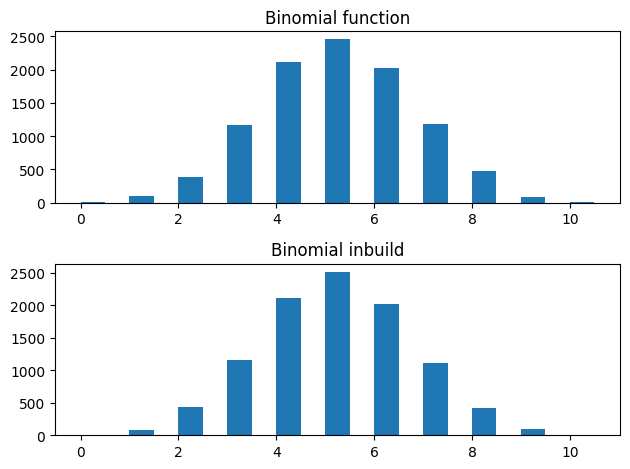

In [648]:
n_binom=10
p_binom = 0.5

# генерация с помощью функции
r, dist = binomial(n_binom, p_binom)

# встроенная генерация
dist_val = binom.rvs(n_binom, p_binom, size=n1)

bin = np.arange(0,n_binom + 1,0.5)
fig, ax = plt.subplots(2, 1)
ax[0].hist(r, bins = bin)
ax[0].set_title('Binomial function')
ax[1].hist(dist_val, bins = bin)
ax[1].set_title('Binomial inbuild') 
fig.tight_layout()
plt.show()

Хи-квадрат для Биномиального распределения

In [649]:
def expected_binomial(m, p):
    last = 2 * math.floor(m * p)
    freq_exp = []
    sum_prob = 0
    for i in range(last):
        prob = binompmf(i, m, p)
        sum_prob += prob
        freq_exp.append(prob * n1)
    freq_exp.append(n1 * (1 - sum_prob))
    return freq_exp

def observed_binomial(sample, m, p):
    last = 2 * math.floor(m * p)
    f_obs = []
    for i in range(last + 1):
        f_obs.append(0)
    sample_sorted = sorted(sample)
    for elem in sample_sorted:
        if elem < last:
            f_obs[elem] += 1
        else:
            f_obs[last] += 1
    return f_obs

freq_exp = expected_binomial(n_binom, p_binom)
freq_obs = observed_binomial(dist_val, n_binom, p_binom)
chi_2 = chisquare(freq_obs, freq_exp)

freq_exp_my = expected_binomial(n_binom, p_binom)
freq_obs_my = observed_binomial(r, n_binom, p_binom)
chi_2_my = chisquare(freq_obs_my, freq_exp_my)
k = len(freq_exp) - 1
delta = chi2(k - 1).ppf(1 - eps)

print("Биномиальное распределение:")
print("Хи-квадрат для встроенного генератора: {},\n\
Хи-квадарат для реализованного генератора: {}\n\
Дельта: {}".format(chi_2, chi_2_my, delta))

Биномиальное распределение:
Хи-квадрат для встроенного генератора: 9.49751873015873,
Хи-квадарат для реализованного генератора: 15.230862222222221
Дельта: 16.918977604620448


Геометрическое распределение

In [650]:
def geom_pmf(p, x):
    return p * (1-p)**(x-1)
def geom_rnd(p, n=n1):
    q = 1 - p
    t = [math.floor(math.log(mmg.U[i]) / math.log(q)) + 1  for i in range(n)]
    return t

Генерация геометрического распределения

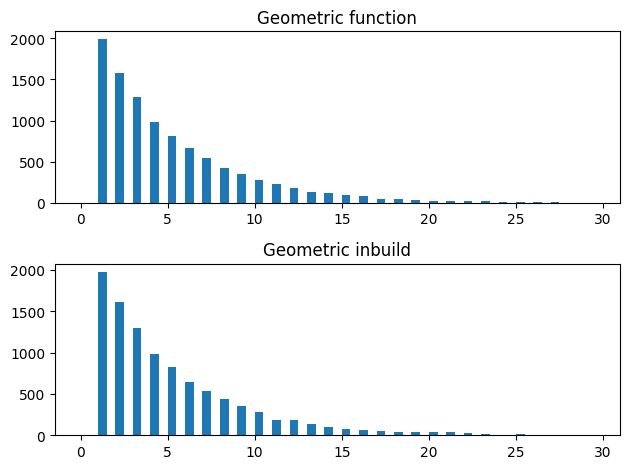

In [651]:
p_geom = 0.2

# генерация с помощью функции
geom_sample = geom_rnd(p_geom)

# встроенная генерация
geom_inbuild = geom.rvs(p_geom, size = 10000)

bin = np.arange(0,30,0.5)
fig, ax = plt.subplots(2, 1)
ax[0].hist(geom_sample, bins = bin)
ax[0].set_title('Geometric function')
ax[1].hist(geom_inbuild, bins = bin)
ax[1].set_title('Geometric inbuild') 
fig.tight_layout()
plt.show()

Хи-квадрат для геометрического распределения

In [652]:
last = math.floor(2 / p_geom)
def expected_geom(p):
    freq_exp = []
    sum_prob = 0
    for i in range(1, last):
        prob = geom_pmf(p, i)
        sum_prob += prob
        freq_exp.append(prob * n1)
    freq_exp.append(n1 * (1 - sum_prob))
    return freq_exp

def observed_geom(sample):
    f_obs = [0 for i in range(1, last + 1)]
    sample_sorted = sorted(sample)
    for elem in sample_sorted:
        if elem < last:
            f_obs[elem - 1] += 1
        else:
            f_obs[last - 1] += 1
    return f_obs

freq_exp = expected_geom(p_geom)
freq_obs = observed_geom(geom_inbuild)
chi_2 = chisquare(freq_obs, freq_exp)

freq_exp_my = expected_geom(p_geom)
freq_obs_my = observed_geom(geom_sample)
chi_2_my = chisquare(freq_obs_my, freq_exp_my)
k = len(freq_exp) - 1
delta = chi2(k - 1).ppf(1 - eps)

print("Геометрическое распределение:")
print("Хи-квадрат для встроенного генератора: {},\n\
Хи-квадарат для реализованного генератора: {}\n\
Дельта: {}".format(chi_2, chi_2_my, delta))

Геометрическое распределение:
Хи-квадрат для встроенного генератора: 4.770147371292028,
Хи-квадарат для реализованного генератора: 4.915468444824377
Дельта: 15.507313055865453


Отрицательное биномиальное распределение

In [653]:
def binom_negative_pmf(k, x, p):
    return combination(k + x - 1, x)*(p**k)*((1-p)**(x))

def binomial_negative(k, p):
    geometr =[math.floor(math.log(mmg.U[i]) / math.log(1-p)) for i in range(k*n1)]
    r = [sum(geometr[i:(i+k)]) for i in range(0, k * n1, k)]
    dist = [binom_negative_pmf(x, k, p) for x in r]
    return r, dist

Генерация отрицательного биномиального распределения

10000


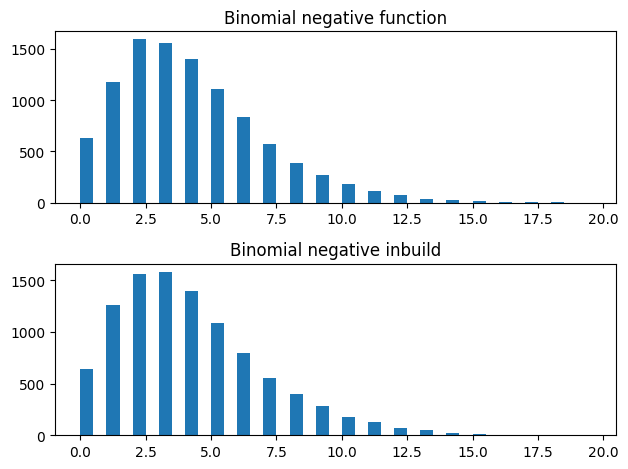

In [654]:
n_bern_neg = 4
p_ber_neg = 0.5

# генерация с помощью функции
r_neg, dist_neg = binomial_negative(n_bern_neg, p_ber_neg)
print(len(r_neg))
# встроенная генерация
dist_val_neg = nbinom.rvs(n_bern_neg, p_ber_neg, size = n1)

bin = np.arange(0,20,0.5)
fig, ax = plt.subplots(2, 1)
ax[0].hist(r_neg, bins = bin)
ax[0].set_title('Binomial negative function')
ax[1].hist(dist_val_neg, bins =bin)
ax[1].set_title('Binomial negative inbuild') 
fig.tight_layout()
plt.show()


Хи-квадрат для отрицательного биномиального распределения

In [655]:
def expected_binomneg(k, p):
    last = 2 * math.floor(k * (1-p) / p)
    freq_exp = []
    sum_prob = 0
    for i in range(last):
        prob = binom_negative_pmf(i, k, p)
        sum_prob += prob
        freq_exp.append(prob * n1)
    freq_exp.append(n1 * (1 - sum_prob))
    return freq_exp

def observed_binomneg(sample, k, p):
    last = 2 * math.floor(k * (1 - p) / p)
    f_obs = []
    for i in range(last + 1):
        f_obs.append(0)
    sample_sorted = sorted(sample)
    for elem in sample_sorted:
        if elem < last:
            f_obs[elem] += 1
        else:
            f_obs[last] += 1
    return f_obs

freq_exp = expected_binomneg(n_bern_neg, p_ber_neg)
freq_obs = observed_binomneg(dist_val_neg, n_bern_neg, p_ber_neg)
chi_2 = chisquare(freq_obs, freq_exp)

freq_exp_my = expected_binomneg(n_bern_neg, p_ber_neg)
freq_obs_my = observed_binomneg(r_neg, n_bern_neg, p_ber_neg)
chi_2_my = chisquare(freq_obs_my, freq_exp_my)
k = len(freq_exp) - 1
delta = chi2(k - 1).ppf(1 - eps)

print("Отрицательное биномиальное распределение:")
print("Хи-квадрат для встроенного генератора: {},\n\
Хи-квадарат для реализованного генератора: {}\n\
Дельта: {}".format(chi_2, chi_2_my, delta))
    

Отрицательное биномиальное распределение:
Хи-квадрат для встроенного генератора: 6466.812257945491,
Хи-квадарат для реализованного генератора: 5982.187881880804
Дельта: 14.067140449340167


Распределение Пуассона

In [656]:
def poisson_pmf(l, x):
    return math.e**(-1* l) * l**x / math.factorial(x)

def poisson_my(l):
    res = []
    for i in range(n1):
        n = 0
        pp = poisson_pmf(l, 0)
        u = mmg.U[i]
        while u > pp:
            n = n + 1
            pp = pp + poisson_pmf(l, n)
        res.append(n)
    print(len(res))
    return res

Генерация распределения Пуассона

10000

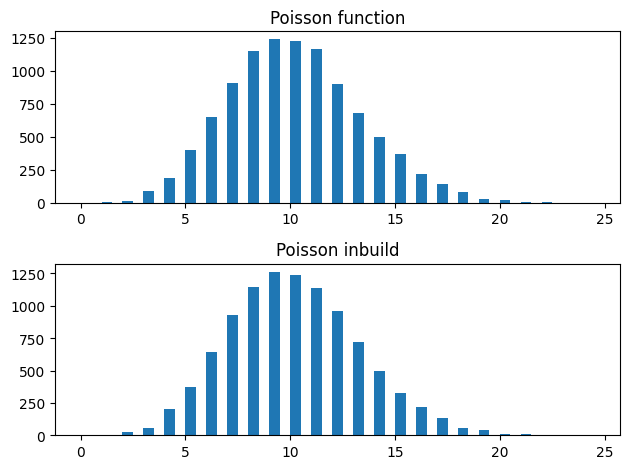

In [657]:
l = 10
# генерация с помощью функции
poiss_sample = poisson_my(l)

# встроенная генерация
poisson_inbuild = poisson.rvs(l, size=10000)

bin = np.arange(0,25,0.5)
fig, ax = plt.subplots(2, 1)
ax[0].hist(poiss_sample, bins = bin)
ax[0].set_title('Poisson function')
ax[1].hist(poisson_inbuild, bins = bin)
ax[1].set_title('Poisson inbuild') 
fig.tight_layout()
plt.show()

Хи-квадрат для распределения Пуассона

In [658]:
last = 2 * l
def expected_puasson(l):
    freq_exp = []
    sum_prob = 0
    for i in range(last + 1):
        prob = poisson_pmf(l, i)
        sum_prob += prob
        freq_exp.append(prob * n1)
    freq_exp.append(n1 * (1 - sum_prob))
    return freq_exp

def observed_puasson(sample, l):
    f_obs = []
    for i in range(last + 2):
        f_obs.append(0)
    sample_sorted = sorted(sample)
    for elem in sample_sorted:
        if elem <= last:
            f_obs[elem] += 1
        else:
            f_obs[last + 1] += 1
    return f_obs

freq_exp = expected_puasson(l)
freq_obs = observed_puasson(poisson_inbuild, l)
chi_2 = chisquare(freq_obs, freq_exp)

freq_exp_my = expected_puasson(l)
freq_obs_my = observed_puasson(poiss_sample, l)
chi_2_my = chisquare(freq_obs_my, freq_exp_my)
k = len(freq_exp) - 1
delta = chi2(k - 1).ppf(1 - eps)

print("Распределение Пуассона:")
print("Хи-квадрат для встроенного генератора: {},\n\
Хи-квадарат для реализованного генератора: {}\n\
Дельта: {}".format(chi_2, chi_2_my, delta))

Распределение Пуассона:
Хи-квадрат для встроенного генератора: 23.68595775522631,
Хи-квадарат для реализованного генератора: 21.7575972533959
Дельта: 31.410432844230918


Гипергеометрическое распределение

In [659]:
def hgeom(k, M, n, N):
    return combination(n, k) * combination(M -n, N - k) / combination(M, N)

def hypergeometric(N, K, k, n):
    x = []
    p = K / N
    for i in range(n):
        sum = 0
        iteration = 0
        for j in range(1, k+1):
            iteration +=1
            if mmg.U[i * k + j - 1] <= p:
                sum += 1
                if sum == K:
                    x.append(sum)
                    break
            p = (K- sum) / (N - j) 
        if iteration == k:
            x.append(sum) 
    return x

Генерация гипергеометрического распределения

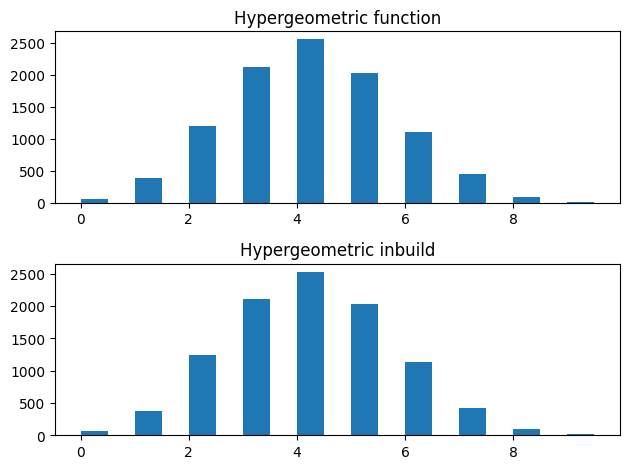

In [660]:
N = 500
K = 200
k = 10
n = 10000
# генерация с помощью функции
hypergeom_sample = hypergeometric(N, K, k, n)

# встроенная генерация
hypergeom_inbuild = hypergeom.rvs(N, K, k, size=10000)

bin = np.arange(0,10,0.5)
fig, ax = plt.subplots(2, 1)
ax[0].hist(hypergeom_sample, bins = bin)
ax[0].set_title('Hypergeometric function')
ax[1].hist(hypergeom_inbuild, bins = bin)
ax[1].set_title('Hypergeometric inbuild') 
fig.tight_layout()
plt.show()


Хи-квадрат для гипергеометрического распределения

In [661]:
last = math.floor(K * k / N)
def expected_hypergeom(M, n, N):
    freq_exp = []
    sum_prob = 0
    for i in range(1, last):
        prob = hgeom(i, M, n, N)
        sum_prob += prob
        freq_exp.append(prob * n1)
    freq_exp.append(n1 * (1 - sum_prob))
    return freq_exp

def observed_hypergeom(sample):
    f_obs = [0 for i in range(1, last + 1)]
    sample_sorted = sorted(sample)
    for elem in sample_sorted:
        if elem < last:
            f_obs[elem - 1] += 1
        else:
            f_obs[last - 1] += 1
    return f_obs
freq_exp = expected_hypergeom(N, k, K)
freq_obs = observed_hypergeom(hypergeom_inbuild)
chi_2 = chisquare(freq_obs, freq_exp)

freq_exp_my = expected_hypergeom(N, k, K)
freq_obs_my = observed_hypergeom(hypergeom_sample)
chi_2_my = chisquare(freq_obs_my, freq_exp_my)
k = len(freq_exp) - 1
delta = chi2(k - 1).ppf(1 - eps)

print("Распределение Гипергеометрическое:")
print("Хи-квадрат для встроенного генератора: {},\n\
Хи-квадарат для реализованного генератора: {}\n\
Дельта: {}".format(chi_2, chi_2_my, delta))

Распределение Гипергеометрическое:
Хи-квадрат для встроенного генератора: 3.0742858090036593,
Хи-квадарат для реализованного генератора: 1.426345492814645
Дельта: 5.991464547107979


Точечная оценка параметра распределения Бернулли

In [664]:
P_ = sum(bernoulli_sample[:n1]) / n1
print("Точечная оценка параметра распределения Бернулли: ", P_)

Точечная оценка параметра распределения Бернулли:  0.4072


Доверительный интервал для параметра распределения Бернулли

In [665]:
param1 = math.sqrt(P_*(1-P_) / n1)
param2 = norm.ppf((1+0.95) / 2)
l = P_ - param1*param2
u = P_ + param1*param2
print("Доверительный интервал для распределения Бернулли:\n\
 l: {},\n\
 u: {}.".format(l, u))

Доверительный интервал для распределения Бернулли:
 l: 0.3975704482116605,
 u: 0.4168295517883395.
